In [1]:
import os
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.jet()

<Figure size 432x288 with 0 Axes>

In [2]:
from lsst.obs.lsst.lsstCamMapper import LsstCamMapper
mapper = LsstCamMapper()
cam = mapper.camera

/home/bxin/lsst_stack/obs_lsst/python/lsst/obs/lsst/lsstCamMapper.py:157: FutureWarning: Replaced by FilterLabel. Will be removed after v22.
  for n in afwImage.Filter.getNames():


In [3]:
rnames = []
dnames = []
for det in cam:
    rname, dname = det.getName().split('_')
    if not rname in rnames:
        if not rname in ["R00", "R04", "R40", "R44"]:
            if not len(rname)>3:
                rnames.append(rname)
    if not dname in dnames:
        if "SG" in dname or "SW" in dname:   # ignore CR
            continue
        dnames.append(dname)
print('%d science rafts found'%len(rnames))
print('each rafts has %d CCDs'%len(dnames))

21 science rafts found
each rafts has 9 CCDs


In [4]:
def get_m5all(f, nraft=21):
    '''
    f is filter, can be u,g,r,i,z,y
    '''
    m5all = []
    procCList = ('R32', 'R03', 'R11', 'R21')
    for rname in rnames:
        if nraft == 17 and rname in procCList:
            continue
        m5dfFile = 'm5_output/%s/m5df_%s.csv'%(rname,rname)
        if os.path.isfile(m5dfFile):
            #print('found data for raft %s'%rname)
            df = pd.read_csv(m5dfFile, index_col=0, dtype=object)
            for dname in dnames:
                key = rname+'_'+dname
                res = df[key].apply(literal_eval)[f]
                for res1 in res:
                    m5all.append(res1)
    #print('%s band, found %.0f rafts'%(f, len(m5all)/16/9))
    while -1 in m5all:
        #get rid of the dead channels, we account for them in fF.
        m5all.remove(-1)
    #print(sum([1 if ele<0 else 0 for ele in m5all]))
    return m5all

In [14]:
m5design = np.array([23.9, 25.0, 24.7, 24.0, 23.3, 22.1]) #SRD Table 6
m5min = np.array([23.4, 24.6, 24.3, 23.6, 22.9, 21.7])
m52019 = np.array([23.74, 24.82, 24.37, 23.94, 23.36, 22.45])
m52020 = np.array([24.1, 24.9, 24.4, 24.0, 23.4, 22.5])

#### Note: the SRD *median* in Tables 5 and 6 refers to median condition, not median over the devices. Since we are using fiducial atmosphere, this is already the median condition. Averaging over the devices is good enough for this purpose (by Zeljko), even though it doesn't project anything onto the time axis.
Table 7 is about variation over devices.

u
17% brighter than average-0.2 mag
6% brighter than average-0.4 mag
g
6% brighter than average-0.2 mag
2% brighter than average-0.4 mag
r
5% brighter than average-0.2 mag
1% brighter than average-0.4 mag
i
4% brighter than average-0.2 mag
1% brighter than average-0.4 mag
z
3% brighter than average-0.2 mag
1% brighter than average-0.4 mag
y
3% brighter than average-0.2 mag
1% brighter than average-0.4 mag


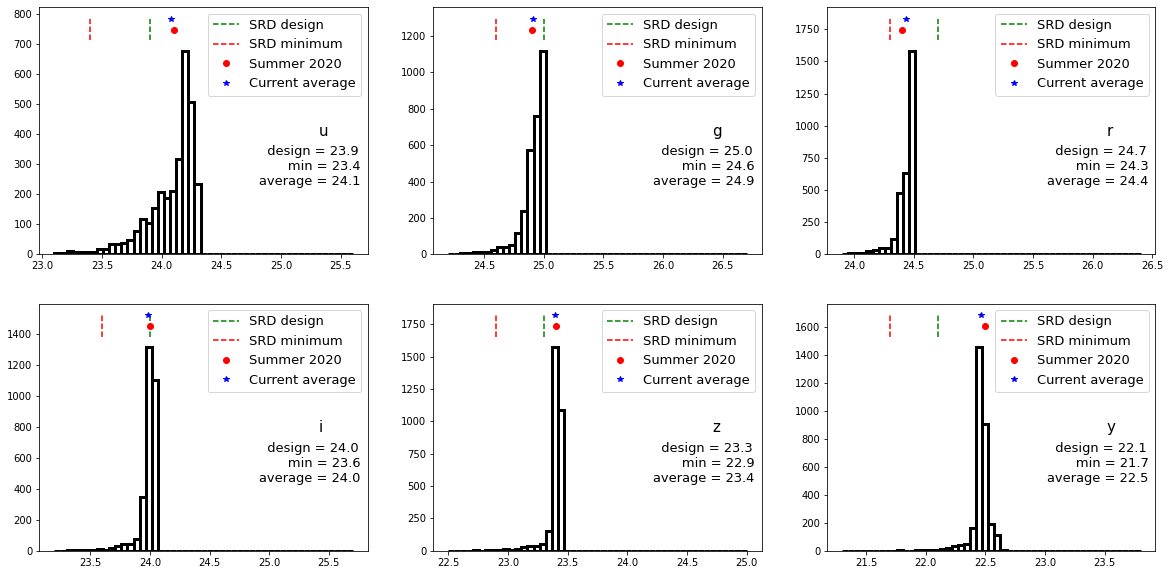

In [25]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
fig, ax = plt.subplots(2,3,figsize=(20,5*2))

for i,f in enumerate(filterlist):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    m5 = np.array(get_m5all(f))
    #m5 = np.array(get_m5all(f, 17))
    mm5 = np.mean(m5)
    #break
    binlow = m5design[i]-0.8
    binhigh = binlow+2.5
    bins = np.linspace(binlow, binhigh,50)
    ax[irow][icol].hist(m5, bins, fill=False, linewidth=3)
    (y1, y2) = (ax[irow][icol].get_ylim())
    ax[irow][icol].plot([m5design[i], m5design[i]],[y2, y2*1.1],linestyle = '--', color='g', label='SRD design') #linewidth=5
    ax[irow][icol].plot([m5min[i], m5min[i]],[y2, y2*1.1],linestyle = '--', color='r', label='SRD minimum') #linewidth=5, 
    ax[irow][icol].plot(m52020[i], y2*1.05, 'ro', label='Summer 2020')
    ax[irow][icol].plot(mm5, y2*1.1, 'b*', label='Current average')
    ax[irow][icol].text(0.85, 0.48, f, color = 'black', transform=ax[irow][icol].transAxes, fontsize=15)
    ax[irow][icol].text(0.67, 0.28, '  design = %.1f\n       min = %.1f\naverage = %.1f'%(m5design[i], m5min[i], mm5), 
                        color = 'black', transform=ax[irow][icol].transAxes, fontsize=13)
    ax[irow][icol].legend(fontsize=13, loc = 'upper right')
    
    #SRD Table 7.
    mm5 = np.log10(np.mean(10**(0.8*(m5))))/0.8
    print(f)
    print('%.0f%% brighter than average-0.2 mag'%(sum(m5<mm5-0.2)/m5.shape[0]*100 ))
    print('%.0f%% brighter than average-0.4 mag'%(sum(m5<mm5-0.4)/m5.shape[0]*100 ))


With regard to SRD Table 5, we are failing the design spec, but meets the minimum easily

In [7]:
a=np.array(m5)

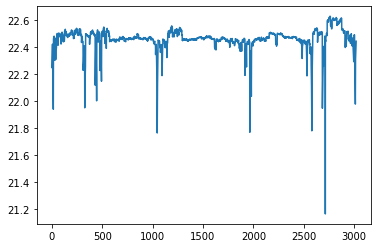

In [8]:
plt.plot(a)

In [9]:
dfPath = os.path.join('m5_output', 'm5_master_db.csv')
mdf = pd.read_csv(dfPath, index_col=0)

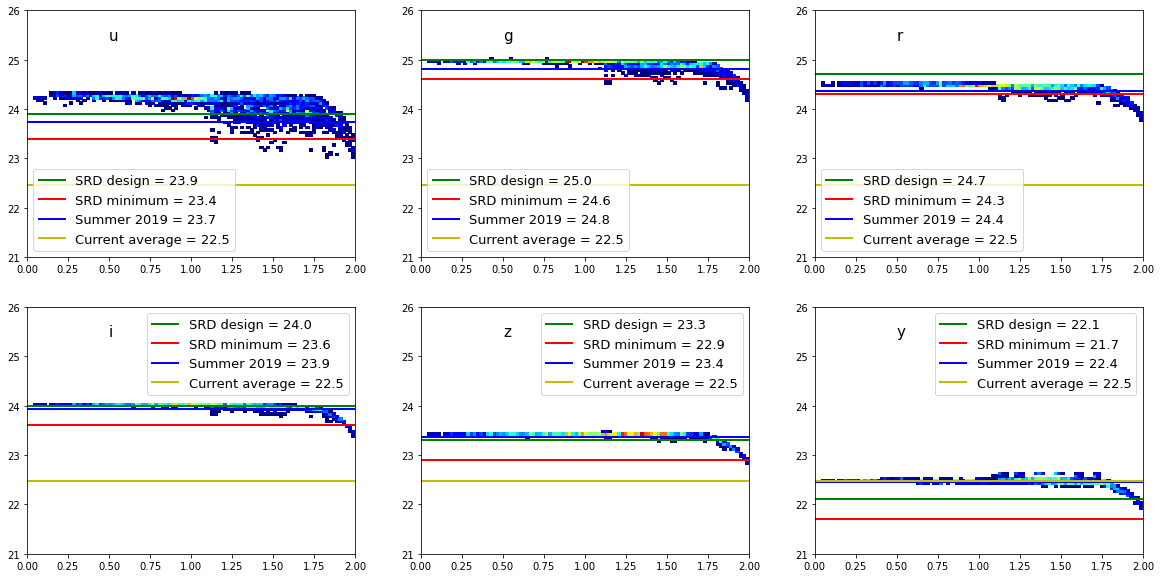

In [10]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
for i,f in enumerate(filterlist):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    #print(f)
    ax[irow][icol].hist2d(mdf['fieldR(deg)'], mdf['m5_%s'%f], range=[[0,2],[21, 26]], bins=100, cmin=1)
    #ax[irow][icol].scatter(mdf['fieldR(deg)'], mdf['m5_%s'%f])
    ax[irow][icol].set_ylim([21,26])
    ax[irow][icol].plot([0,2],[m5design[i], m5design[i]], linewidth=2, color='g', label='SRD design = %.1f'%m5design[i])
    ax[irow][icol].plot([0,2],[m5min[i], m5min[i]], linewidth=2, color='r', label='SRD minimum = %.1f'%m5min[i])
    ax[irow][icol].plot([0,2],[m52019[i], m52019[i]], linewidth=2, color='b', label='Summer 2019 = %.1f'%m52019[i])
    ax[irow][icol].plot([0,2],[mm5, mm5], linewidth=2, color='y', label='Current average = %.1f'%mm5)
    ax[irow][icol].text(0.25, 0.88, f, color = 'black', transform=ax[irow][icol].transAxes, fontsize=15)
    if i<3:
        ax[irow][icol].legend(fontsize=13, loc='lower left')
    else:
        ax[irow][icol].legend(fontsize=13)
